# Well Log Visualization
## Plotting and interactive cross-ploting well curves in LAS files
### Author: Amir Abbas Babasafari (AB) 
### Date: March 2024
### Email: a.babasafari@yahoo.com
### IDE: Jupyter Notebook
### Python version: 3.9

#####

### Import Libraries
#### Please run the cell below

In [1]:
import os
import sys
import numpy as np
import pandas as pd 
import lasio 
import copy
from matplotlib import pyplot as plt
from tkinter import *
from tkinter import filedialog
import ipywidgets as widgets
from ipywidgets import interact

### Load single/multiple LAS file(s)

#### Please run the cell below, click on 'open a file' button on pop-up window to select your single/multiple well logs in LAS format, followed by clicking on the 'close the window' button.

In [2]:
def load_las_files():
    '''
    Function to load a bunch of las files
    
    Return file path of loaded las files
    '''
    
    global filespath
    
    # Open file name
    file = filedialog.askopenfilenames(initialdir = os.getcwd(),
    title = "Please select las files",
    filetypes = [('las files','*.las'),('All files','*.*')])
    filespath = file
    print("File_path: {0}".format(filespath))
    
# Create root window
root = Tk()
root.geometry('300x200')  
root.title('LAS File')

# Open button to click in a GUI toolkit
open_button1 = Button(root, text = "Open Files", command = load_las_files)
open_button2 = Button(root, text = "Close the Window", command = root.destroy)
open_button1.pack()
open_button2.pack()

# Run the application
root.mainloop()

File_path: ('E:/AB_2023/Visualization/Data for test plus bri data/logs_las/1/F02-1_logs.las', 'E:/AB_2023/Visualization/Data for test plus bri data/logs_las/1/F03-2_logs.las', 'E:/AB_2023/Visualization/Data for test plus bri data/logs_las/1/F03-4_logs.las', 'E:/AB_2023/Visualization/Data for test plus bri data/logs_las/1/F06-1_logs.las')


### Read well logs and create a dataframe for all log types
#### Please run the cell below

In [3]:
def read_las_files(filespath):

    """     
    Function to read well logs from LAS files and create a dataframe for all log types
    
    Parameter:
    ----------
    filespath (str): file path of loaded LAS files
    
    Returns:
    --------
    Merged_Dataset (pandas.core.frame.DataFrame): merged dataframe includes all well logs for all wells

    Author: Amir Abbas Babasafari (AB)
    """

    log_name_all_wells = []
    for file in filespath:
        well_curves = lasio.read(file)
        log_name = well_curves.keys()
        log_name_all_wells.append(log_name)
    
    wells_logs_type = np.unique([a for b in log_name_all_wells for a in b])
    
    curves_all_wells = []
    for file in filespath:
        well_curves = lasio.read(file)
        well_name = os.path.splitext(os.path.basename(file))[0] 
        log_name = well_curves.keys()

        try:
            try:
                depth = well_curves['DEPTH']
            except:
                depth = well_curves['DEPT']
        except:
            print('Depth column is neither specified in DEPTH nor DEPT, so please check it in your las files and modify the name in the function.')
            
        curves_per_well = []
        for log in wells_logs_type:
            if log in log_name:
                curve_per_well = well_curves[log]
            else:
                curve_per_well =  np.repeat(np.nan, len(depth))
            curves_per_well.append(curve_per_well)
        curves_single_well = np.column_stack(curves_per_well)
        curves_single_well_pd = pd.DataFrame(curves_single_well, columns=wells_logs_type)
        curves_single_well_pd['well_name'] = np.repeat(well_name, len(depth))
        curves_all_wells.append(curves_single_well_pd)
    Merged_Dataset = pd.concat(curves_all_wells, ignore_index=True)
    return wells_logs_type, Merged_Dataset

# Implement the function above
wells_log_name, Merged_Dataset_pd = read_las_files(filespath)
Merged_Dataset_pd

,AI,AI_REL,DEPTH,DT,GR,PHIE,RHOB,well_name
0,3820257.00,-4.556956e+02,48.0000,524.0485,NaN,NaN,NaN,F02-1_logs
1,3820311.75,-4.556956e+02,48.1500,524.0410,NaN,NaN,NaN,F02-1_logs
2,3820366.25,-4.556956e+02,48.3000,524.0336,NaN,NaN,NaN,F02-1_logs
3,3820419.75,-4.556956e+02,48.4500,524.0262,NaN,NaN,NaN,F02-1_logs
4,3820472.25,-4.556956e+02,48.6000,524.0190,NaN,NaN,NaN,F02-1_logs
...,...,...,...,...,...,...,...,...
47352,5515911.50,-6.817655e+04,1699.3401,408.5790,65.3096,0.2477,2253.6553,F06-1_logs
47353,5568257.00,-6.817655e+04,1699.4901,405.6664,66.8890,0.2445,2258.8062,F06-1_logs
47354,5608718.00,-6.817655e+04,1699.6400,403.4365,68.4500,0.2420,2262.7539,F06-1_logs
47355,5626381.00,2.700981e+06,1699.7900,402.4676,68.9515,0.2410,2264.4343,F06-1_logs


### Plot all well logs for all wells
#### Please run the cell below

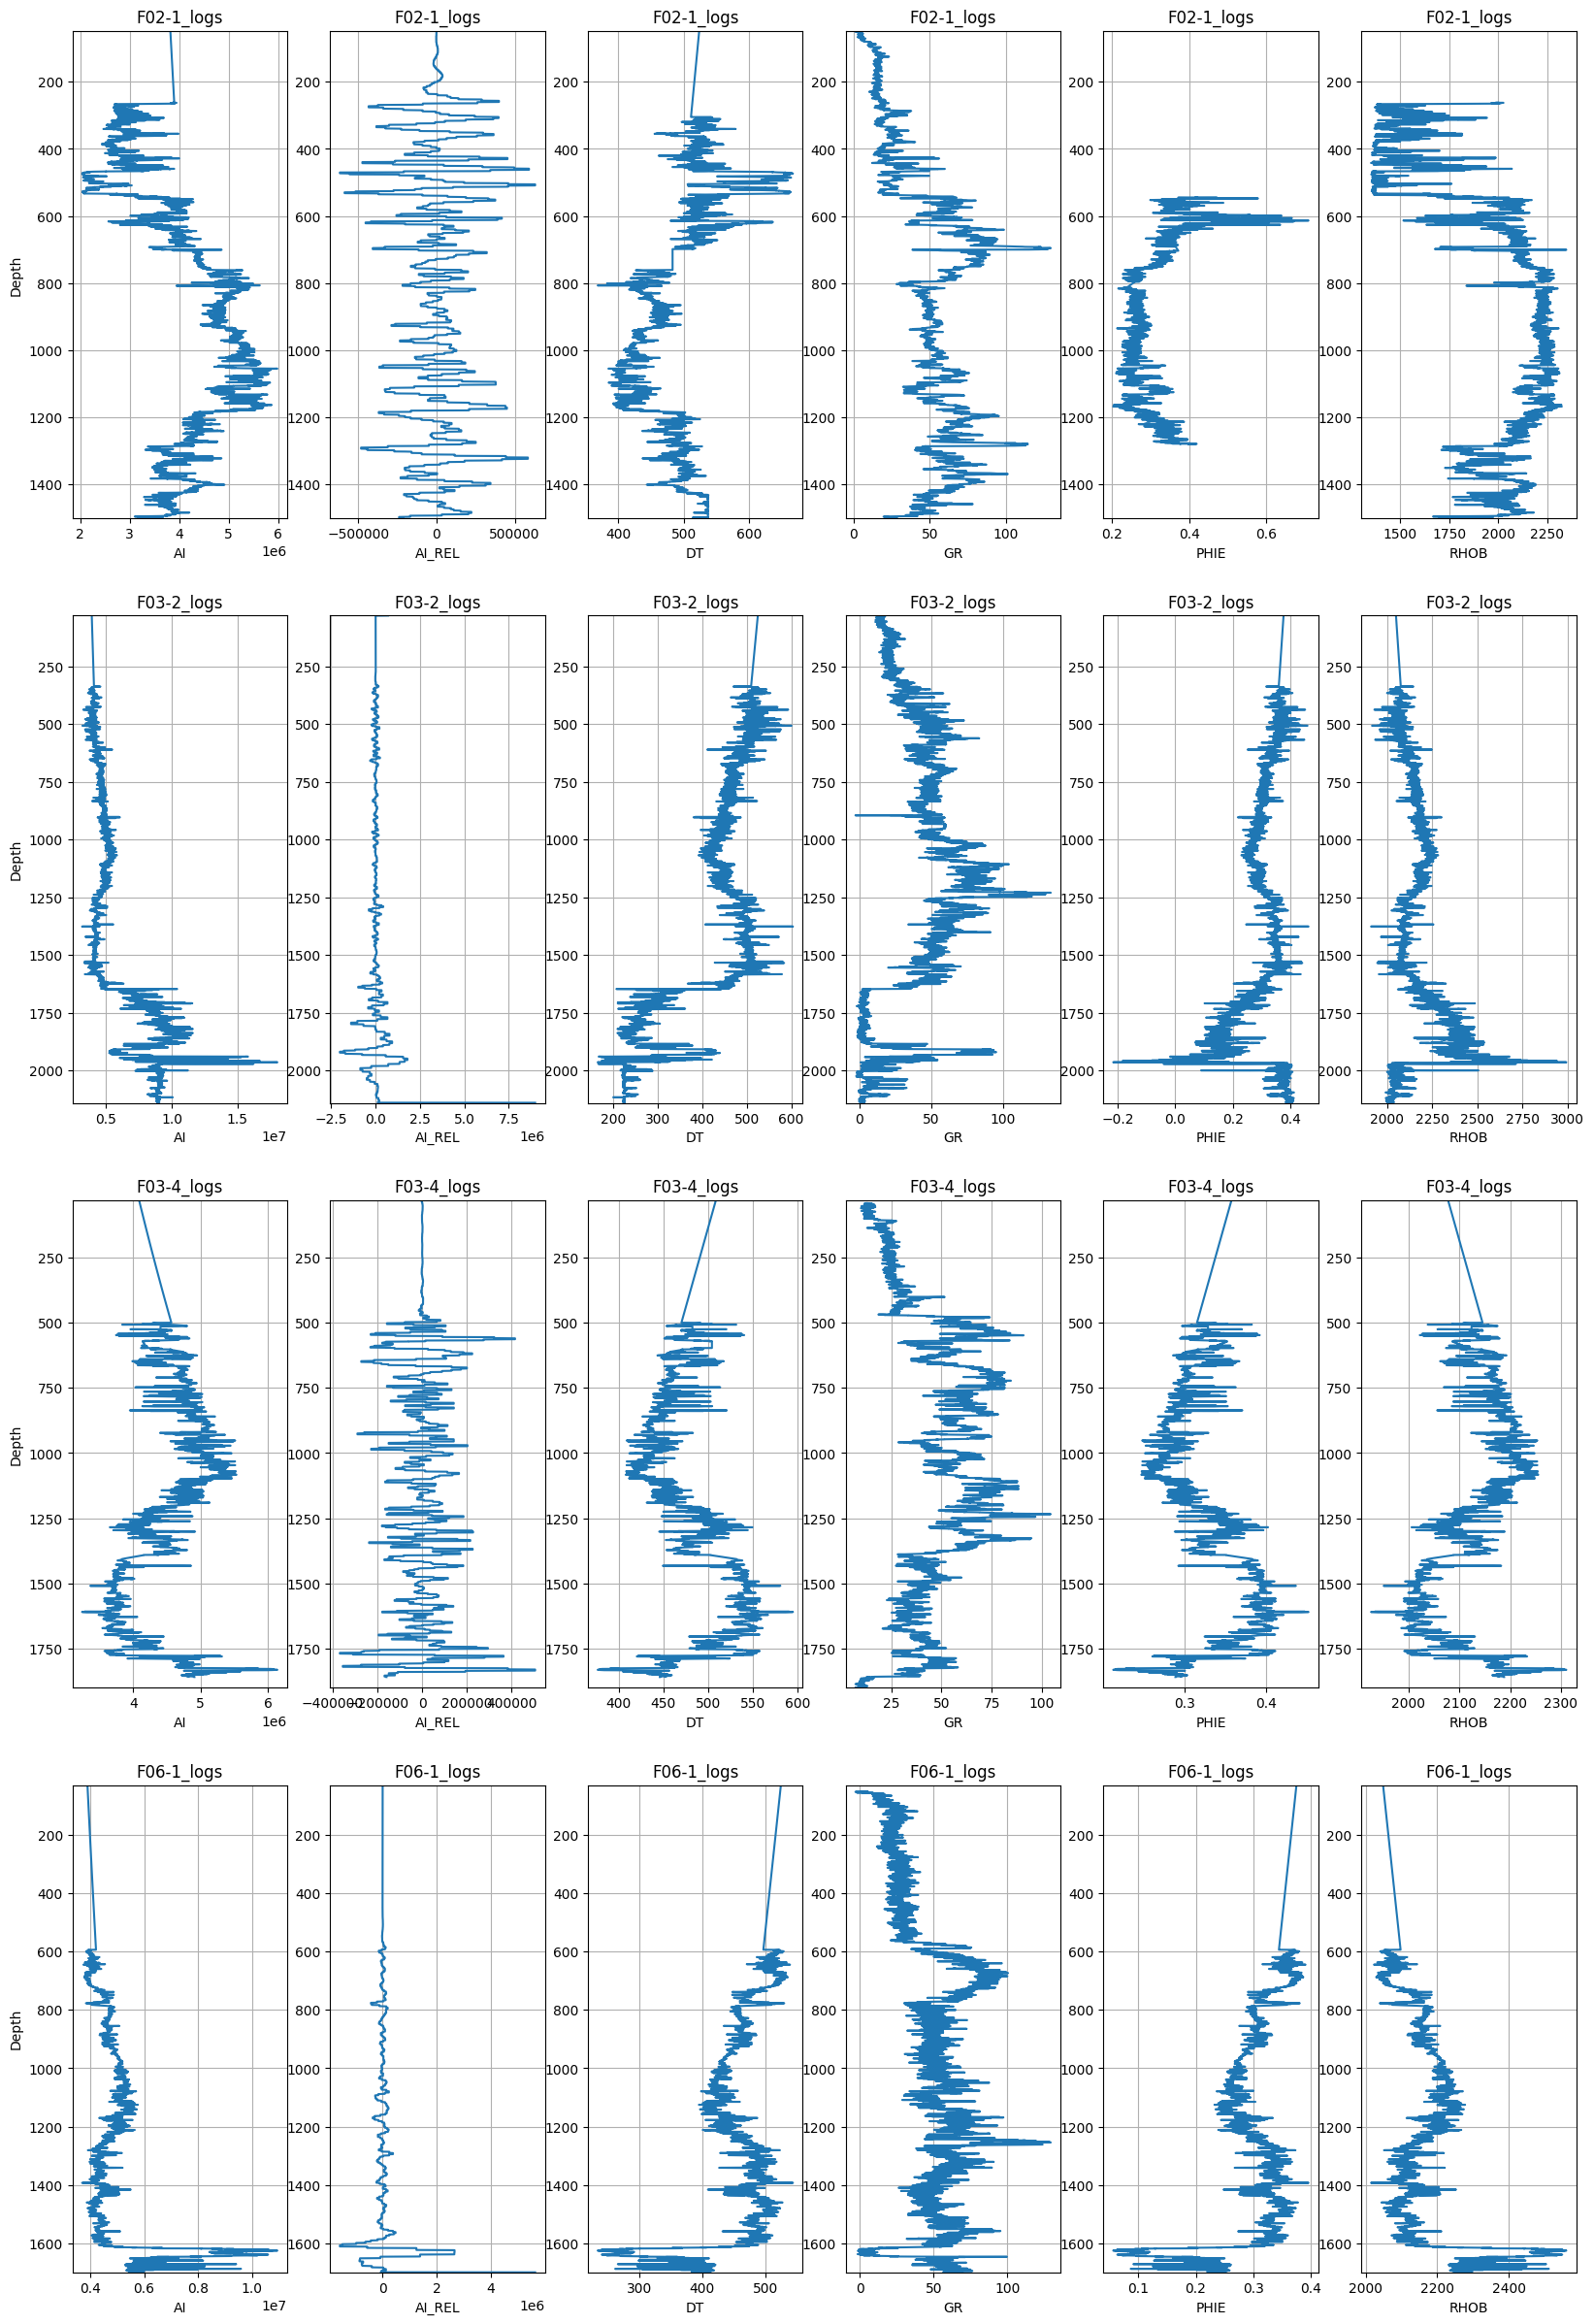

In [4]:
def logs_plot_per_well(logs):
    '''
    Function to plot well logs
    '''

    well_name = Merged_Dataset_pd["well_name"].unique().tolist()
    log = copy.deepcopy(logs)
    try:
        log.drop(['DEPTH','well_name'], axis='columns', inplace=True)
    except:
        log.drop(['DEPT','well_name'], axis='columns', inplace=True)
    
    fig, ax=plt.subplots(nrows=len(well_name), ncols=len(log.columns), figsize=(20,30), squeeze=False)
    for i in range(len(log.columns)):
        for j in range(len(well_name)):
            figure = ax[j][i]
            try:
                Depth = logs[logs['well_name']==well_name[j]].DEPTH
            except:
                Depth = logs[logs['well_name']==well_name[j]].DEPT
            figure.plot(log[logs['well_name']==well_name[j]].iloc[:,i], Depth)
            figure.set_title(f"{well_name[j]}")
            figure.set_xlabel(log.columns[i])  
            ax[j][0].set_ylabel('Depth')
            figure.set_ylim(min(Depth), max(Depth))
            figure.invert_yaxis()
            figure.grid()
            
logs_plot_per_well(Merged_Dataset_pd)

### Cross-plot all well logs for all wells
#### Please run the cell below

In [5]:
well_name = Merged_Dataset_pd["well_name"].unique().tolist()
property_list = list(Merged_Dataset_pd.columns)
property_list.remove('well_name')

def cross_plot(well, property1, property2, property3):

    '''
    Function to cross-plot well logs
    '''
    plt.scatter(Merged_Dataset_pd[str(property1)][Merged_Dataset_pd['well_name']==str(well)],Merged_Dataset_pd[str(property2)][Merged_Dataset_pd['well_name']==str(well)],
                c=Merged_Dataset_pd[property3][Merged_Dataset_pd['well_name']==str(well)],cmap=plt.cm.jet)
    plt.title(f"{property1} vs. {property2} color_coded with {property3} at well {well}")
    plt.xlabel(f"{property1}")
    plt.ylabel(f"{property2}")
    plt.legend([str(property3)],loc='upper right')
    plt.colorbar()
    plt.grid()
    plt.show()

### Interactive Cross-plot Visualization
#### Please run the cell below

In [6]:
@interact(property=widgets.SelectionSlider(options=property_list, description='Colour_Code'))
def interactive_colorcoded_crossplot(property, Well_Name=well_name, X_Axis=wells_log_name, Y_Axis=wells_log_name):   
    cross_plot(Well_Name, X_Axis, Y_Axis, property)

interactive(children=(SelectionSlider(description='Colour_Code', options=('AI', 'AI_REL', 'DEPTH', 'DT', 'GR',…

### Thank you for your attention

##### AB